In [1]:
import cv2
import numpy as np

# بارگذاری تصویر
path = "4.jpg"
image = cv2.imread(path)

# تبدیل تصویر به خاکستری
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# اعمال بلور برای کاهش نویز
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# شناسایی دایره‌های مربوط به قرص‌ها
circles = cv2.HoughCircles(
    blurred, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2, 
    minDist=50, 
    param1=50, 
    param2=30, 
    minRadius=10, 
    maxRadius=50
)

# رسم دایره‌های شناسایی‌شده (قرص‌ها) و پیدا کردن هاله‌ها
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # مرکز و شعاع قرص
        center = (i[0], i[1])
        radius = i[2]
        
        # رسم دایره برای قرص
        cv2.circle(image, center, radius, (0, 255, 0), 2)
        cv2.circle(image, center, 2, (0, 0, 255), 3)  # مرکز قرص

        # شناسایی هاله‌ها (دایره بزرگ‌تر)
        # شعاع احتمالی هاله بزرگ‌تر از قرص است
        for r in range(radius + 10, radius + 100, 5):  # جستجو برای شعاع‌های بزرگ‌تر
            mask = np.zeros_like(gray)
            cv2.circle(mask, center, r, 255, -1)  # ماسک برای شعاع فعلی
            masked_region = cv2.bitwise_and(gray, gray, mask=mask)
            
            # بررسی تفاوت روشنایی در مرزهای شعاع برای تشخیص دایره (هاله)
            mean_intensity = cv2.mean(masked_region, mask=mask)[0]
            if mean_intensity < 200:  # اگر روشنایی کمتر باشد، هاله تشخیص داده می‌شود
                cv2.circle(image, center, r, (255, 0, 0), 2)
                break

# ذخیره تصویر خروجی
output_path = "pill_and_halo_detected.jpg"
cv2.imwrite(output_path, image)

print(f"تصویر خروجی ذخیره شد: {output_path}")


تصویر خروجی ذخیره شد: pill_and_halo_detected.jpg


In [2]:
import cv2
import numpy as np

# بارگذاری تصویر
path = "4.jpg"
image = cv2.imread(path)

# تبدیل تصویر به خاکستری
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# بهبود کنتراست تصویر با استفاده از CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray = clahe.apply(gray)

# شناسایی قرص‌ها با Hough Circle Transform
circles = cv2.HoughCircles(
    enhanced_gray, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2, 
    minDist=50, 
    param1=50, 
    param2=30, 
    minRadius=10, 
    maxRadius=50
)

# رسم قرص‌ها و جستجوی هاله‌های اطراف
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # مرکز و شعاع قرص
        center = (i[0], i[1])
        radius = i[2]

        # رسم دایره برای قرص
        cv2.circle(image, center, radius, (0, 255, 0), 2)  # دایره قرص
        cv2.circle(image, center, 2, (0, 0, 255), 3)      # مرکز قرص

        # استخراج ناحیه هاله اطراف قرص
        mask = np.zeros_like(gray)
        cv2.circle(mask, center, radius + 70, 255, -1)  # شعاع بزرگ‌تر برای هاله
        cv2.circle(mask, center, radius, 0, -1)         # حذف ناحیه قرص از ماسک
        halo_region = cv2.bitwise_and(enhanced_gray, enhanced_gray, mask=mask)

        # پیدا کردن کانتورهای هاله
        contours, _ = cv2.findContours(
            halo_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 100:  # فیلتر کردن کانتورهای کوچک
                (x, y), r = cv2.minEnclosingCircle(contour)
                cv2.circle(image, (int(x), int(y)), int(r), (255, 0, 0), 2)  # رسم هاله

# ذخیره تصویر خروجی
output_path = "pill_and_halo_detected.jpg"
cv2.imwrite(output_path, image)

print(f"تصویر خروجی ذخیره شد: {output_path}")


تصویر خروجی ذخیره شد: pill_and_halo_detected.jpg


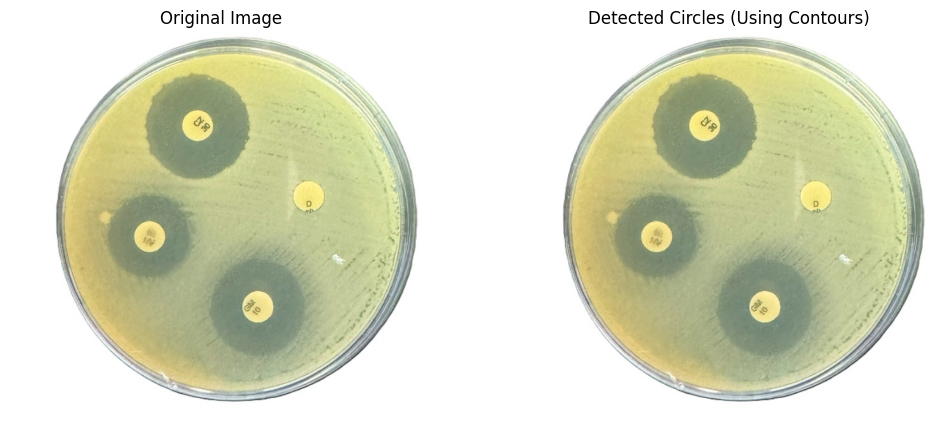

In [30]:
import cv2
import numpy as np
import csv

def preprocess_image(image):
    """Apply Gaussian blur and convert to HSV color space."""
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    return hsv

def create_mask(hsv, lower_color, upper_color):
    """Create a binary mask based on the color range."""
    mask = cv2.inRange(hsv, lower_color, upper_color)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

def find_pills(mask, min_radius, max_radius, circularity_threshold):
    """Find contours of pills and filter based on circularity and size."""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centers = []
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        area = cv2.contourArea(contour)
        circularity = area / (np.pi * radius * radius) if radius > 0 else 0
        if min_radius < radius < max_radius and circularity > circularity_threshold:
            centers.append((int(x), int(y), int(radius)))
    return centers

def draw_pills(image, centers):
    """Draw circles around detected pills."""
    for (x, y, radius) in centers:
        cv2.circle(image, (x, y), radius, (0, 0, 255), 2)
    return image

def save_data(centers, output_file):
    """Save centers data to a CSV file."""
    with open(output_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["X", "Y", "Radius"])
        writer.writerows(centers)

# Main code
def main(image_path, output_image, output_csv):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Parameters
    lower_yellow = np.array([15, 90, 150])
    upper_yellow = np.array([35, 255, 255])
    min_radius = 12
    max_radius = 100
    circularity_threshold = 0.9

    # Processing pipeline
    hsv = preprocess_image(image)
    mask = create_mask(hsv, lower_yellow, upper_yellow)
    centers = find_pills(mask, min_radius, max_radius, circularity_threshold)
    result_image = draw_pills(image, centers)

    # Save results
    cv2.imwrite(output_image, result_image)
    save_data(centers, output_csv)
    print(f"Detection completed. Results saved to {output_image} and {output_csv}")

# Example usage
main("4.jpg", "pill.jpg", "pill_data.csv")
